In [1]:
pip install catboost


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### 1. *Import LIBRARIES*


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt

## 2. *Load Dataset*

In [3]:
df = pd.read_csv("crop_yield.csv")
df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()

### 3. *DISPLAYING DATASET*

In [4]:
df

,crop,crop_year,season,state,area,production,annual_rainfall,fertilizer,pesticide,yield
0,Arecanut,1997,Whole Year,Assam,73814.0,56708,2051.4,7024878.38,22882.34,0.796087
1,Arhar/Tur,1997,Kharif,Assam,6637.0,4685,2051.4,631643.29,2057.47,0.710435
2,Castor seed,1997,Kharif,Assam,796.0,22,2051.4,75755.32,246.76,0.238333
3,Coconut,1997,Whole Year,Assam,19656.0,126905000,2051.4,1870661.52,6093.36,5238.051739
4,Cotton(lint),1997,Kharif,Assam,1739.0,794,2051.4,165500.63,539.09,0.420909
...,...,...,...,...,...,...,...,...,...,...
19684,Small millets,1998,Kharif,Nagaland,4000.0,2000,1498.0,395200.00,1160.00,0.500000
19685,Wheat,1998,Rabi,Nagaland,1000.0,3000,1498.0,98800.00,290.00,3.000000
19686,Maize,1997,Kharif,Jammu and Kashmir,310883.0,440900,1356.2,29586735.11,96373.73,1.285000
19687,Rice,1997,Kharif,Jammu and Kashmir,275746.0,5488,1356.2,26242746.82,85481.26,0.016667


## 3. *Data Cleansing*
Data cleansing improves data quality by fixing errors, removing duplicates, handling missing values, and standardizing formats. This ensures accurate analysis, reliable insights, and better-performing models.

In [5]:
df = df.drop_duplicates()
df = df[(df['area'] > 0) & (df['production'] >= 0)]
low, high = df['yield'].quantile([0.005, 0.995])
df['yield'] = df['yield'].clip(low, high)

## 4. *Feature Engineering*
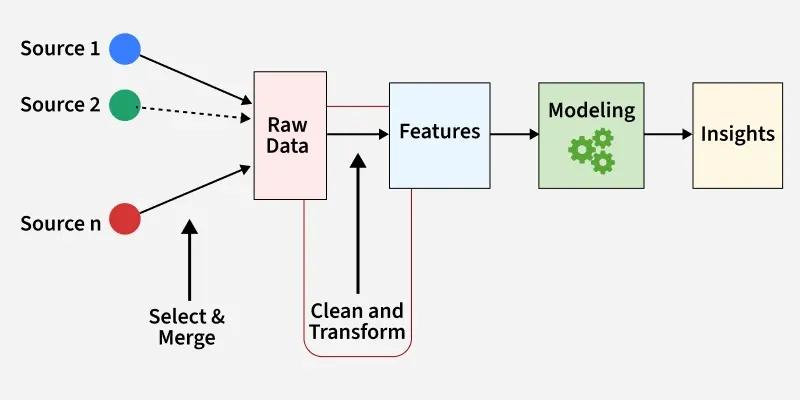

Feature engineering is the process of creating, modifying, or selecting features (columns) from raw data to make it more suitable for machine learning models. Good features help models learn patterns better and improve accuracy.

In [6]:
df = df.drop(columns=['production'])
df['decade'] = (df['crop_year'] // 10) * 10
df['rainfall_fertilizer_ratio'] = df['annual_rainfall'] / (df['fertilizer'] + 1)
df['fert_pest_ratio'] = df['fertilizer'] / (df['pesticide'] + 1)


In [7]:
df['yield_lag1'] = df.groupby(['state','crop'])['yield'].shift(1)
df['yield_lag2'] = df.groupby(['state','crop'])['yield'].shift(2)

### 5. *Train / Validation Split*

In [8]:
train = df[df['crop_year'] <= 2016]
valid = df[df['crop_year'] > 2016]

In [9]:
features = [c for c in df.columns if c not in ['yield']]
cat_features = ['crop','season','state']

In [10]:
train_pool = Pool(train[features], train['yield'], 
                  cat_features=cat_features) 
valid_pool = Pool(valid[features], valid['yield'], 
                  cat_features=cat_features)

### 6. *BaseLine Model*
Baseline model is a simple initial model used to set a reference point for performance. It helps you compare and measure improvements when building more complex models.

In [11]:
dummy = DummyRegressor(strategy="mean")

## 7. *CatBoost Model*
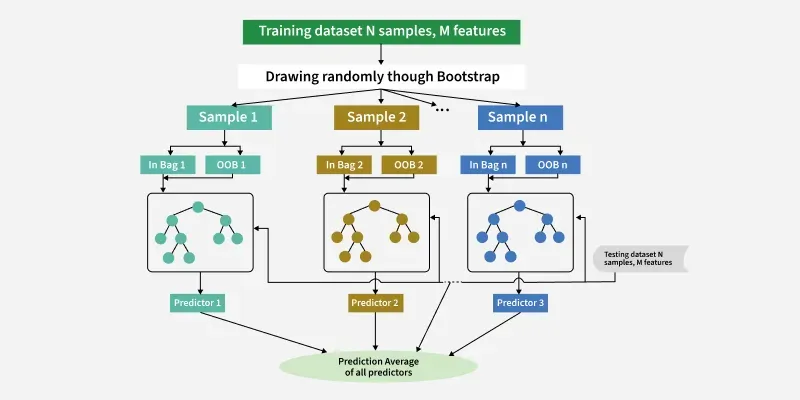
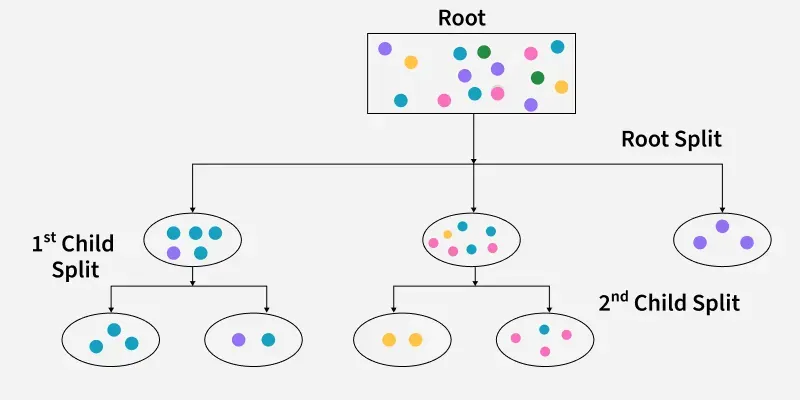

Handles Categorical Features Easily – Variables are naturally categorical. CatBoost processes them directly without manual encoding.

High Accuracy on Tabular Data – Crop datasets often have structured, tabular data. CatBoost performs very well on such datasets.

Reduces Overfitting – Ordered boosting in CatBoost helps the model generalize better, giving more reliable yield predictions.

Fast Training with GPU Support – Useful if your dataset is large (e.g., multiple states, years, and weather data).

Robust Out-of-the-Box Performance – Even with minimal hyperparameter tuning, it gives strong results, saving time.


In [12]:
model = CatBoostRegressor(
    depth=8,
    learning_rate=0.05,
    iterations=2000,
    loss_function='RMSE',
    eval_metric='RMSE',
    early_stopping_rounds=100,
    random_seed=42,
    verbose=200
)
model.fit(train_pool,eval_set = valid_pool)

0:	learn: 600.3482800	test: 580.2478697	best: 580.2478697 (0)	total: 207ms	remaining: 6m 53s
200:	learn: 35.6335163	test: 48.8464854	best: 48.7923626 (198)	total: 8.69s	remaining: 1m 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 48.78380568
bestIteration = 229

Shrink model to first 230 iterations.


### 8. *Evaluation*

In [13]:
valid['pred'] = model.predict(valid[features])
rmse = np.sqrt(mean_squared_error(valid['yield'], valid['pred']))
mae = mean_absolute_error(valid['yield'], valid['pred'])
r2 = r2_score(valid['yield'], valid['pred'])

print(f"Validation RMSE: {rmse:.2f}")
print(f"Validation MAE: {mae:.2f}")
print(f"Validation R2: {r2:.3f}")


Validation RMSE: 48.78
Validation MAE: 5.10
Validation R2: 0.993


C:\Users\SuVarShA\AppData\Local\Temp\ipykernel_9468\1994272272.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = model.predict(valid[features])


### *Model Comparison Plots*
RMSE, R², MAE for each model:

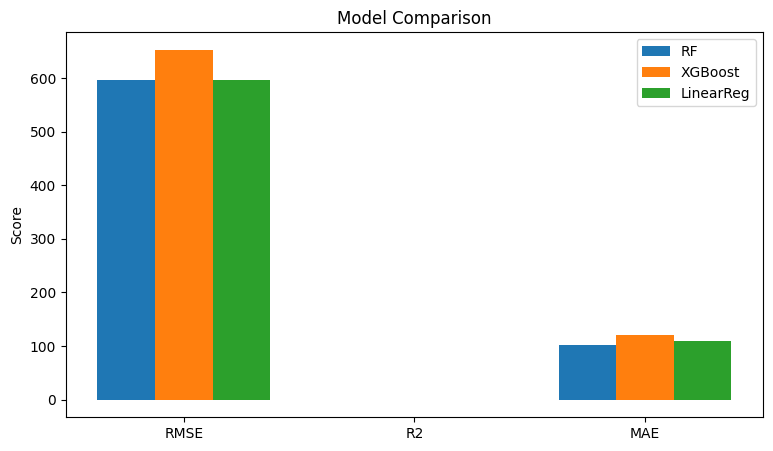

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Prepare data
features = ['annual_rainfall', 'fertilizer', 'pesticide']
X = df[features]
y = df['yield']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train models
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
lr_pred = lr_model.predict(X_test)

# Calculate metrics
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)

xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_r2 = r2_score(y_test, xgb_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)

lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_r2 = r2_score(y_test, lr_pred)
lr_mae = mean_absolute_error(y_test, lr_pred)

# Model comparison plot
metrics = ['RMSE', 'R2', 'MAE']
models = ['RF', 'XGBoost', 'LinearReg']
results = [
    [rf_rmse, rf_r2, rf_mae],
    [xgb_rmse, xgb_r2, xgb_mae],
    [lr_rmse, lr_r2, lr_mae]
]

import numpy as np
metrics_pos = np.arange(len(metrics))
bar_width = 0.25

plt.figure(figsize=(9,5))
for i, model in enumerate(models):
    plt.bar(metrics_pos + i*bar_width, results[i], width=bar_width, label=model)

plt.xticks(metrics_pos + bar_width, metrics)
plt.ylabel('Score')
plt.title('Model Comparison')
plt.legend()
plt.show()


## 9. *Feature Importance*

Feature importance tells us how much each input variable (feature) contributes to the predictions of a machine learning model. It helps identify which factors have the biggest impact on the target.
Like:
Rainfall, temperaturemight be more important than fertilizer type.
Helps focus on key factors affecting crop yield.
Guides feature selection and improves model interpretability.

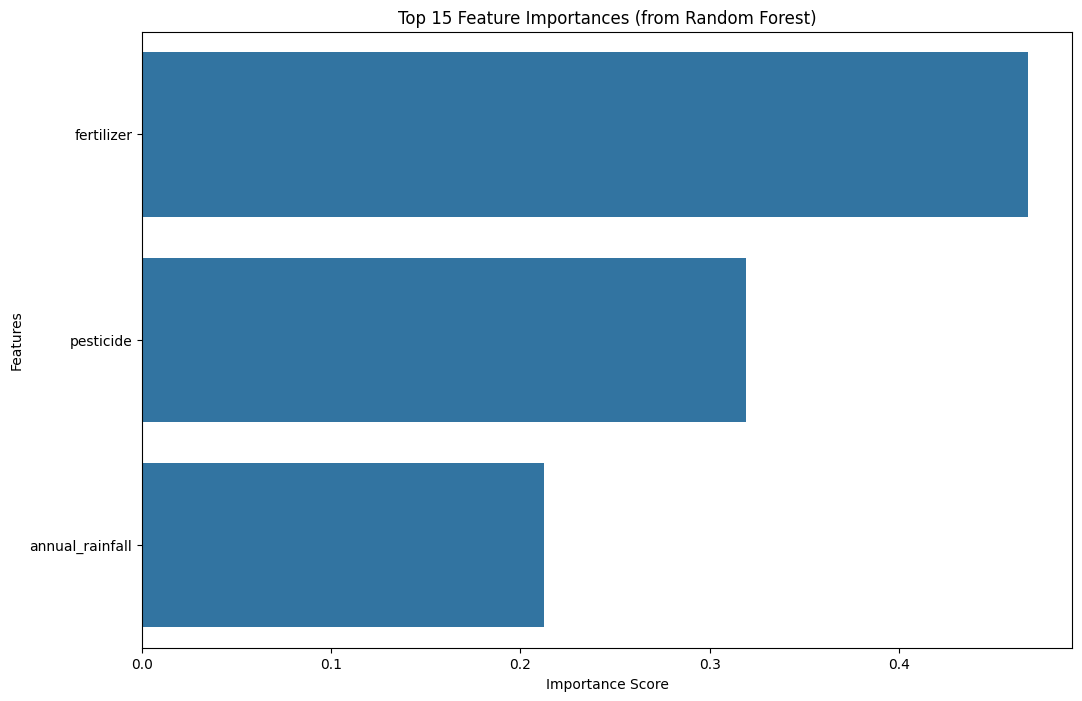

           feature  importance
1       fertilizer    0.468088
2        pesticide    0.319336
0  annual_rainfall    0.212576


In [15]:
import seaborn as sns
importances = rf_model.feature_importances_

# Get the names of the features
feature_names = X_train.columns

# Create a pandas DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False) # Sort by importance

# --- Visualize the Feature Importances ---

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15)) # Display top 15 features
plt.title('Top 15 Feature Importances (from Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

print(feature_importance_df)

#### 10. *PLOTTING*

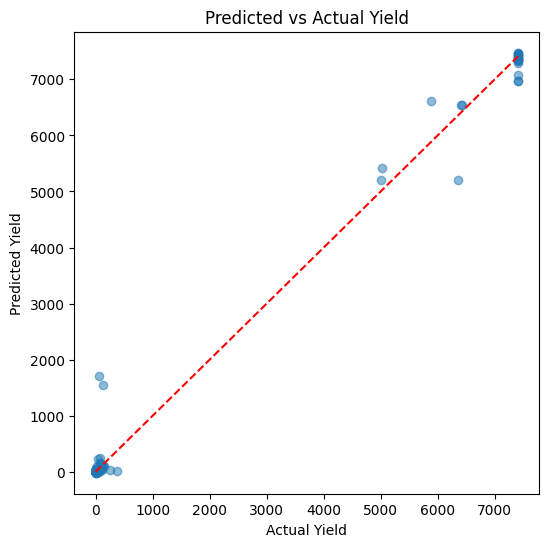

In [16]:
plt.figure(figsize=(6,6)) 
plt.scatter(valid['yield'], valid['pred'], alpha=0.5) 
plt.plot([valid['yield'].min(), valid['yield'].max()], [valid['yield'].min(), valid['yield'].max()], 'r--') 
plt.xlabel("Actual Yield") 
plt.ylabel("Predicted Yield") 
plt.title("Predicted vs Actual Yield") 
plt.show()

### *Rainfall Trends Across Decades and States*

In [17]:
df.columns = df.columns.str.strip().str.lower()
print(df.columns.tolist())


['crop', 'crop_year', 'season', 'state', 'area', 'annual_rainfall', 'fertilizer', 'pesticide', 'yield', 'decade', 'rainfall_fertilizer_ratio', 'fert_pest_ratio', 'yield_lag1', 'yield_lag2']


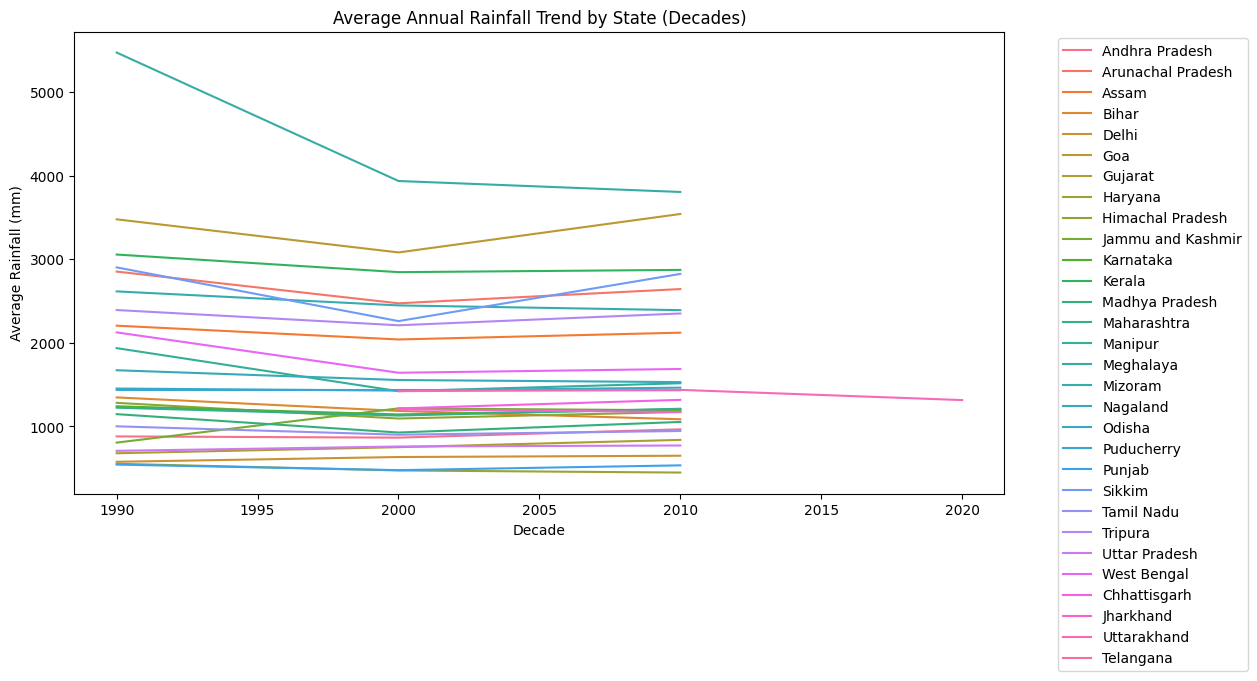

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Rainfall trend by decade
rainfall_decade = df.groupby(['decade','state'])['annual_rainfall'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=rainfall_decade, x='decade', y='annual_rainfall', hue='state')
plt.title("Average Annual Rainfall Trend by State (Decades)")
plt.xlabel("Decade")
plt.ylabel("Average Rainfall (mm)")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()


#### *Correlation Heatmaps (Rainfall, Fertilizer, Pesticide vs Yield)*

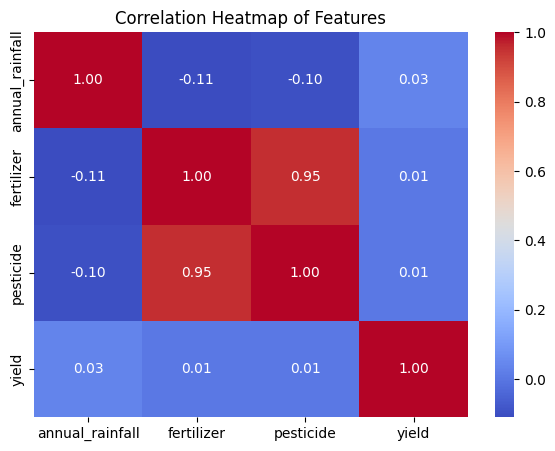

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
features = ['annual_rainfall', 'fertilizer', 'pesticide', 'yield']
corr = df[features].corr()

plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Features')
plt.show()


#### *Scatterplot Matrix (Pair Plot)*
Explore multivariate relationships and spot outliers:

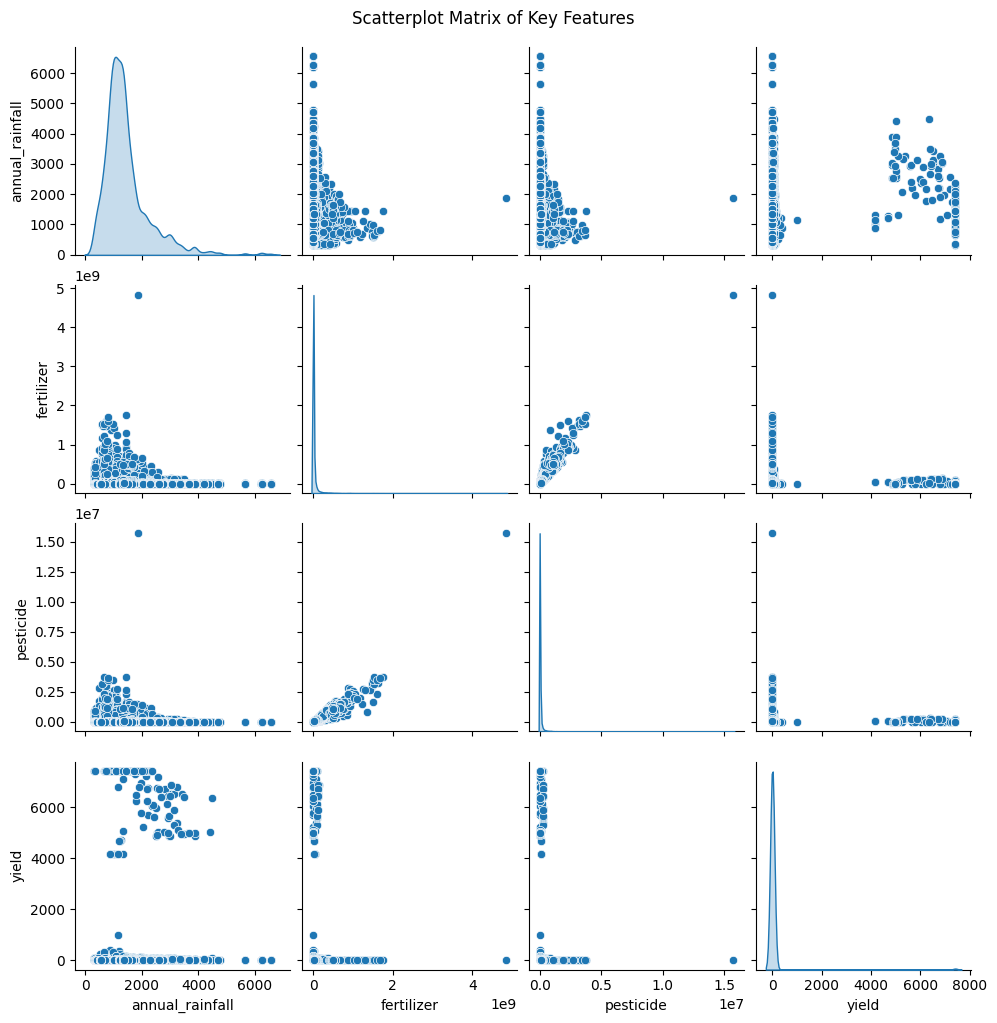

In [20]:
sns.pairplot(df[features], diag_kind="kde")
plt.suptitle('Scatterplot Matrix of Key Features', y=1.02)
plt.show()

### *Feature Importance Bar Graphs (Random Forest)*
After model training, visualize feature importances:

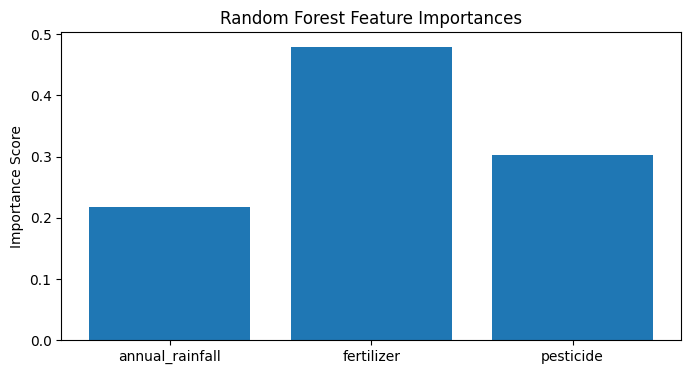

In [21]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Define features and target (e.g., yield)
X = df[['annual_rainfall', 'fertilizer', 'pesticide']]  # Example features
y = df['yield']

# Train Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X, y)

# Plot feature importances
importances = rf_model.feature_importances_
feat_names = X.columns

plt.figure(figsize=(8,4))
plt.bar(feat_names, importances)
plt.title('Random Forest Feature Importances')
plt.ylabel('Importance Score')
plt.show()


### *Feature Importance Bar Graphs (XGBoost)*
After model training, visualize feature importances:

In [22]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


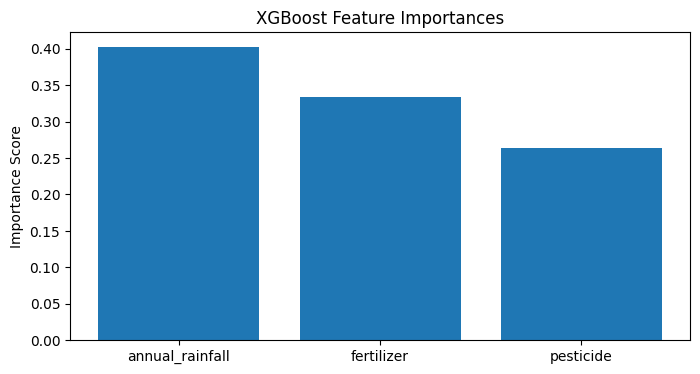

In [23]:
import pandas as pd
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Define features and target variable
X = df[['annual_rainfall', 'fertilizer', 'pesticide']]  # example feature columns
y = df['yield']

# Initialize and train the XGBoost regressor
xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror')
xgb_model.fit(X, y)

# Plot feature importances
importances = xgb_model.feature_importances_
feat_names = X.columns

plt.figure(figsize=(8,4))
plt.bar(feat_names, importances)
plt.title('XGBoost Feature Importances')
plt.ylabel('Importance Score')
plt.show()


### *Which Crops are Most Fertilizer/Pesticide Dependent*


In [24]:
# Group by crop and calculate correlations
crop_corr = (
    df.groupby("crop")[["fertilizer", "pesticide", "yield"]]
      .corr()
      .reset_index()
)

# Keep only rows where the second variable is 'yield'
crop_corr = crop_corr[crop_corr["level_1"] == "yield"]

# Now pivot to get clearer columns
crop_corr = crop_corr.pivot(index="crop", columns="level_1", values=["fertilizer","pesticide"])
crop_corr.columns = ["fertilizer_corr", "pesticide_corr"]

print("Top fertilizer-dependent crops:")
print(crop_corr.sort_values("fertilizer_corr", ascending=False).head(10))

print("\nTop pesticide-dependent crops:")
print(crop_corr.sort_values("pesticide_corr", ascending=False).head(10))


Top fertilizer-dependent crops:
                fertilizer_corr  pesticide_corr
crop                                           
Tapioca                0.739684        0.703258
Arecanut               0.711270        0.679091
Jute                   0.688294        0.673249
Castor seed            0.648721        0.628214
other oilseeds         0.620541        0.663905
Oilseeds total         0.597837        0.497780
Wheat                  0.447305        0.437781
Ginger                 0.426047        0.404197
Mesta                  0.374082        0.314457
Barley                 0.299762        0.279306

Top pesticide-dependent crops:
                fertilizer_corr  pesticide_corr
crop                                           
Tapioca                0.739684        0.703258
Arecanut               0.711270        0.679091
Jute                   0.688294        0.673249
other oilseeds         0.620541        0.663905
Castor seed            0.648721        0.628214
Oilseeds total         0

#### *Geospatial Visualization (Yield by State)*

In [25]:
pip install nbformat --upgrade

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
pip install nbformat


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
pip install jupyterlab

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
print(df.columns.tolist())


['crop', 'crop_year', 'season', 'state', 'area', 'annual_rainfall', 'fertilizer', 'pesticide', 'yield', 'decade', 'rainfall_fertilizer_ratio', 'fert_pest_ratio', 'yield_lag1', 'yield_lag2']


In [29]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
import geopandas as gpd
# Load the shapefile (ensure all files are in the same folder)
gdf = gpd.read_file(r'ne_10m_admin_1_states_provinces\ne_10m_admin_1_states_provinces.shp')



# Filter for India (if required)
india_states = gdf[gdf['admin'] == 'India']

# Save as GeoJSON
india_states.to_file('india_states.geojson', driver='GeoJSON')


In [31]:
# Filter GeoDataFrame for India states (column name might vary, check gdf.columns)
india_states = gdf[gdf['admin'] == 'India']

# Save filtered GeoDataFrame as GeoJSON
india_states.to_file('india_states.geojson', driver='GeoJSON')

print("India states GeoJSON saved as 'india_states.geojson'")


India states GeoJSON saved as 'india_states.geojson'


In [32]:
import json

with open('india_states.geojson', encoding='utf-8') as f:
    geojson = json.load(f)


In [33]:
print([feature['properties']['name'] for feature in geojson['features']])

# Create state_data first if not defined
state_data = df.groupby('state')[['annual_rainfall', 'yield']].mean().reset_index()

print(state_data['state'].unique())


['Ladakh', 'Arunachal Pradesh', 'Sikkim', 'West Bengal', 'Assam', 'Uttarakhand', 'Nagaland', 'Manipur', 'Mizoram', 'Tripura', 'Meghalaya', 'Punjab', 'Rajasthan', 'Gujarat', 'Himachal Pradesh', 'Jammu and Kashmir', 'Bihar', 'Uttar Pradesh', 'Andhra Pradesh', 'Odisha', 'Dadra and Nagar Haveli and Daman and Diu', 'Maharashtra', 'Goa', 'Karnataka', 'Kerala', 'Puducherry', 'Tamil Nadu', 'Lakshadweep', 'Andaman and Nicobar', 'Jharkhand', 'Delhi', 'Chandigarh', 'Madhya Pradesh', 'Chhattisgarh', 'Haryana', 'Telangana']
['Andhra Pradesh' 'Arunachal Pradesh' 'Assam' 'Bihar' 'Chhattisgarh'
 'Delhi' 'Goa' 'Gujarat' 'Haryana' 'Himachal Pradesh' 'Jammu and Kashmir'
 'Jharkhand' 'Karnataka' 'Kerala' 'Madhya Pradesh' 'Maharashtra' 'Manipur'
 'Meghalaya' 'Mizoram' 'Nagaland' 'Odisha' 'Puducherry' 'Punjab' 'Sikkim'
 'Tamil Nadu' 'Telangana' 'Tripura' 'Uttar Pradesh' 'Uttarakhand'
 'West Bengal']


In [34]:
import plotly.graph_objects as go
if not df.empty:
    print("Generating interactive geospatial map file...")
    state_yield = df.groupby('state')['yield'].mean().reset_index()

    try:
        with open('india_states.geojson', encoding='utf-8') as f:
            geojson = json.load(f)
    except FileNotFoundError:
        print("Error: 'india_states.geojson' not found. Map cannot be generated.")
        geojson = None

    if geojson:
        geojson_states = {feature['properties']['name'] for feature in geojson['features']}
        data_states = set(state_yield['state'])
        
        unmapped_states = data_states - geojson_states
        if unmapped_states:
            print(f"Warning: These states are in your data but not found in the map file: {sorted(list(unmapped_states))}")
        
        # Create the choropleth map figure
        fig = go.Figure(go.Choropleth(
            geojson=geojson,
            featureidkey="properties.name",
            locations=state_yield['state'],
            z=state_yield['yield'],
            colorscale='YlGn',
            colorbar_title='Average Yield',
            marker_line_color='darkgray',
            marker_line_width=0.5
        ))
        fig.update_geos(fitbounds="locations", visible=False)
        fig.update_layout(
            title_text='Interactive Map: Average Crop Yield by Indian State',
            title_x=0.5,
            margin={"r":0, "t":40, "l":0, "b":0}
        )
        output_filename = 'india_crop_map.html'
        fig.write_html(output_filename)
        
        print("\n Success! Interactive map has been saved.")
        print(f"--> The file named '{output_filename}' in your directory,")
        print("    download it, and open it with your web browser.")

Generating interactive geospatial map file...

 Success! Interactive map has been saved.
--> The file named 'india_crop_map.html' in your directory,
    download it, and open it with your web browser.


C:\Users\SuVarShA\AppData\Local\Temp\ipykernel_9468\3618044906.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




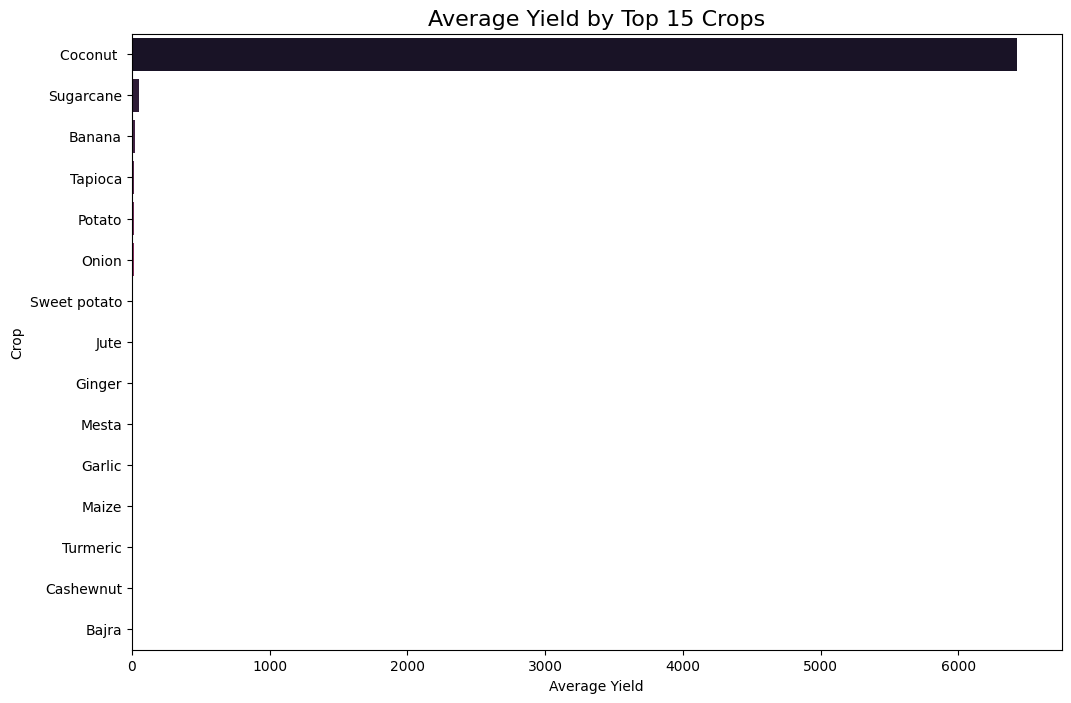

In [35]:
plt.figure(figsize=(12, 8))
crop_yield_mean = df.groupby('crop')['yield'].mean().sort_values(ascending=False).head(15)
sns.barplot(x=crop_yield_mean.values, y=crop_yield_mean.index, palette='rocket')
plt.title('Average Yield by Top 15 Crops', fontsize=16)
plt.xlabel('Average Yield')
plt.ylabel('Crop')
plt.show()

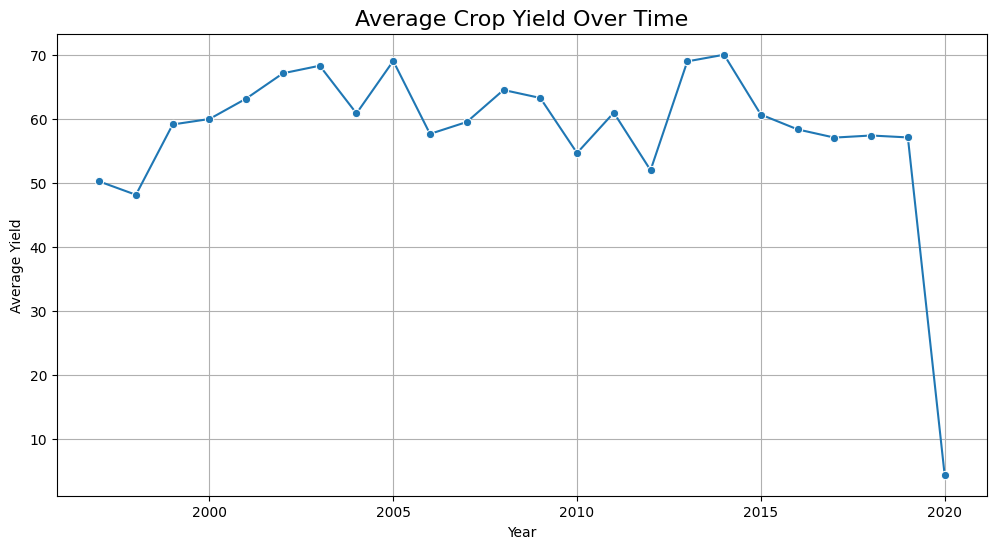

In [36]:
# Add this in your EDA section
plt.figure(figsize=(12, 6))
year_yield_mean = df.groupby('crop_year')['yield'].mean()
sns.lineplot(x=year_yield_mean.index, y=year_yield_mean.values, marker='o')
plt.title('Average Crop Yield Over Time', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Average Yield')
plt.grid(True)
plt.show()

In [37]:
# Import the CatBoostRegressor class
from catboost import CatBoostRegressor
import pickle

# Now you can create an instance of the model without an error
best_model = CatBoostRegressor(verbose=0, random_state=42)
best_model.fit(X_train, y_train) # Make sure to train it on the full training data

# Save the trained model
with open('model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print("Model trained and saved successfully!")

Model trained and saved successfully!


In [38]:
from sklearn.model_selection import GridSearchCV

# Define a smaller set of parameters to search over to start
# This can take a while to run!
param_grid = {
    'iterations': [500, 1000],
    'learning_rate': [0.05, 0.1],
    'depth': [4, 6]
}

# Initialize the model
cb = CatBoostRegressor(verbose=0, random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=cb, param_grid=param_grid, 
                           cv=3, n_jobs=-1, scoring='r2', verbose=2)

# Fit it to your data
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found: ", grid_search.best_params_)

# Get the best model
best_model_tuned = grid_search.best_estimator_

# Now, you would save THIS tuned model to your .pkl file
# with open('model_tuned.pkl', 'wb') as file:
#     pickle.dump(best_model_tuned, file)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters found:  {'depth': 4, 'iterations': 500, 'learning_rate': 0.05}
